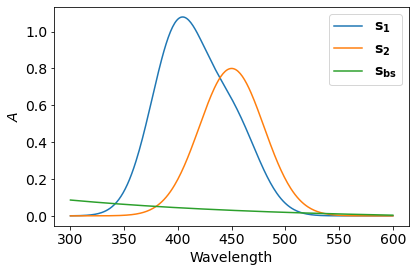

In [1]:
import numpy as np  # import numpy package (abbreviation stands for Numerical Python)
import matplotlib.pyplot as plt  # we plot graphs with this library
import matplotlib
from numba import njit, jit, vectorize, prange
import numba
from typing import Union
from scipy.integrate import odeint
from matplotlib import cm
import matplotlib as mpl
import math
from numpy.linalg import svd
from scipy.integrate import cumtrapz

plt.rcParams.update({'font.size': 14})

def plot_matrix(times: np.ndarray, wavelengths: np.ndarray, D: np.ndarray, zlim=(None, None),
               title='', cmap='hot_r'):
    
    zmin, zmax = zlim[0] if zlim[0] is not None else np.nanmin(D), zlim[1] if zlim[1] is not None else np.nanmax(D)
    
    x, y = np.meshgrid(wavelengths, times)  # needed for pcolormesh to correctly scale the image
    
    plt.pcolormesh(x, y, D, cmap=cmap, shading='auto', vmin=zmin, vmax=zmax)
    plt.colorbar(label='$\Delta A$')
    plt.xlabel('Wavelength $\\rightarrow$')
    plt.ylabel('$\\leftarrow$ Time ')
#     plt.gca().invert_yaxis()
#     plt.yscale('symlog', linthresh=1, linscale=1)
    plt.title(title)
#     plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.show()
    
def save_matrix(D, times, wavelengths, fname='output.txt', delimiter='\t', encoding='utf8'):
    # crop the data if necessary
    mat = np.vstack((wavelengths, D))
    buffer = delimiter + delimiter.join(f"{num}" for num in times) + '\n'
    buffer += '\n'.join(delimiter.join(f"{num}" for num in row) for row in mat.T)

    with open(fname, 'w', encoding=encoding) as f:
        f.write(buffer)

    
wavelengths = np.arange(300, 601)
    
def gauss(x: Union[int, float, np.ndarray], mu: Union[int, float, np.ndarray], 
          sigma: Union[int, float, np.ndarray]) -> np.ndarray:
    return np.exp(-(x - mu) * (x - mu) / (2 * sigma * sigma))

S1 = gauss(wavelengths, 400, 25) + 0.5 * gauss(wavelengths, 450, 25)  # ground state bleach
S2 = 0.8 * gauss(wavelengths, 450, 30)  # excited state absorption band 1
Baseline = 0.05*np.exp(-0.005 * (wavelengths - 450)) - 0.02

S = np.vstack((S1, S2)).T
S_baseline = np.hstack((S, Baseline[:, None]))

# plot individual bands

plt.plot(wavelengths, S1, label='$\\mathbf{s_1}$')
plt.plot(wavelengths, S2, label='$\\mathbf{s_2}$')
plt.plot(wavelengths, Baseline, label='$\\mathbf{s_{bs}}$')

plt.xlabel('Wavelength')
plt.ylabel('$A$')
plt.tight_layout()
plt.legend()
plt.savefig('species.svg', dpi=500)
plt.show()

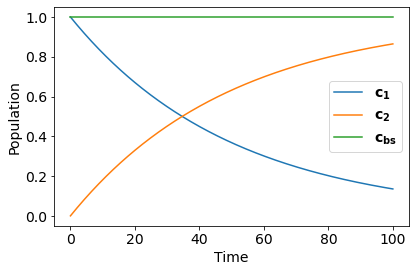

In [2]:
times = np.linspace(0, 100, 400)
k = 0.02
c = np.exp(-k * times)
C = np.vstack((c, 1-c)).T
C_baseline = np.hstack((C, np.ones_like(times)[:, None]))

plt.plot(times, C_baseline[:, 0], label='$\\mathbf{c_1}$')
plt.plot(times, C_baseline[:, 1], label='$\\mathbf{c_2}$')
plt.plot(times, C_baseline[:, 2], label='$\\mathbf{c_{bs}}$')

plt.ylabel('Population')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()

plt.savefig('time_traces.svg', dpi=500)

plt.show()

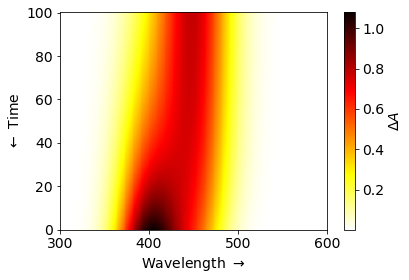

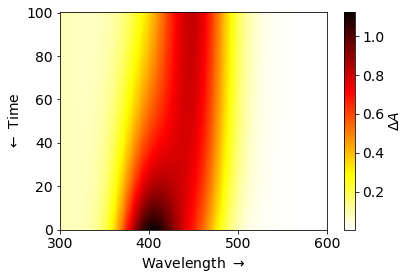

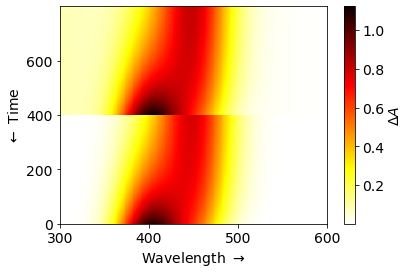

In [3]:
D = C @ S.T
D_baseline = C_baseline @ S_baseline.T

D_mix = np.vstack((D, D_baseline))
t_mix = np.arange(0, D_mix.shape[0], 1)

save_matrix(D, times, wavelengths, fname='D_test.txt')
save_matrix(D_baseline, times, wavelengths, fname='D_baseline_test.txt')

plot_matrix(times, wavelengths, D)
plot_matrix(times, wavelengths, D_baseline)
plot_matrix(t_mix, wavelengths, D_mix)


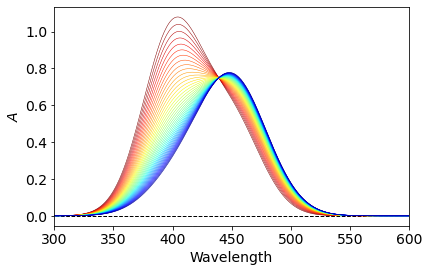

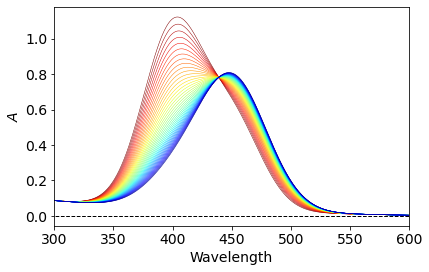

In [4]:
from matplotlib import cm

def plot_dataset(D, filepath=None, step=10):
    cmap = cm.get_cmap('jet_r')

    N = D.shape[0]
    for i in range(0, N, step):
        plt.plot(wavelengths, D[i], lw=0.5, color=cmap(i / N))

    plt.xlabel('Wavelength')
    plt.ylabel('$A$')
    plt.tight_layout()
    plt.xlim(wavelengths[0], wavelengths[-1])
    plt.hlines(0, 0, 1000, ls='--', color='k', lw=1)
    if filepath:
        plt.savefig(filepath, dpi=500)
    plt.show()
    
plot_dataset(D, filepath='Dataset1.svg')
plot_dataset(D_baseline, filepath='Dataset2.svg')

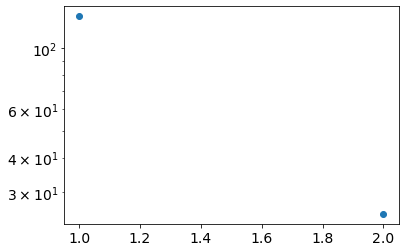

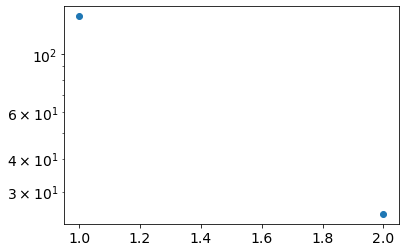

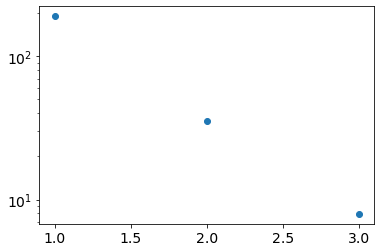

96.60255150497751

In [5]:
def get_svd_vectors(D, rcond=1e-10):
    U, S, VT = svd(D, full_matrices=False)
    cutoff = rcond * S.max()
    large = S > cutoff
    Sr = S[large]
    Ur = U[:, large]
    VrT = VT[large, :]
    
    return Sr, Ur, VrT

def plot_singular_vals(D, rcond=1e-10):
    Sr, Ur, VrT = get_svd_vectors(D, rcond)
    
    plt.scatter(np.arange(1, Sr.shape[0]+1,1), Sr)
    plt.yscale('log')
    plt.show()
    
    return Sr, Ur, VrT

def SVD_power(D, n_vals=2):
    U, S, VT = svd(D, full_matrices=False)
    return 100 * S[:n_vals].sum() / S.sum()
    
Sr, Ur, VrT = plot_singular_vals(D)
Srb, Urb, VrTb = plot_singular_vals(D_baseline)
Srm, Urm, VrTm = plot_singular_vals(D_mix)

SVD_power(D_mix)

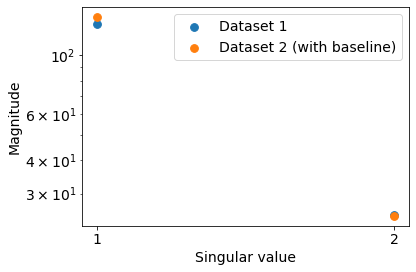

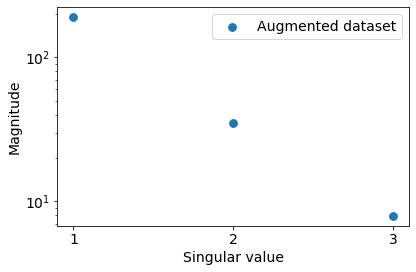

In [6]:
plt.scatter(np.arange(1, Sr.shape[0]+1,1), Sr, label='Dataset 1', s=60)
plt.scatter(np.arange(1, Srb.shape[0]+1,1), Srb, label='Dataset 2 (with baseline)', s=60)
plt.xlabel('Singular value')
plt.ylabel('Magnitude')
plt.xticks([1, 2])
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('S_values.svg')
plt.show()

plt.scatter(np.arange(1, Srm.shape[0]+1,1), Srm, label='Augmented dataset', s=60)
plt.xlabel('Singular value')
plt.ylabel('Magnitude')
plt.xticks([1, 2, 3])
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('S_values_mix.svg')
plt.show()

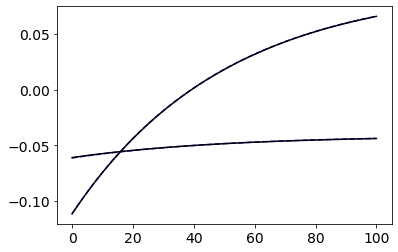

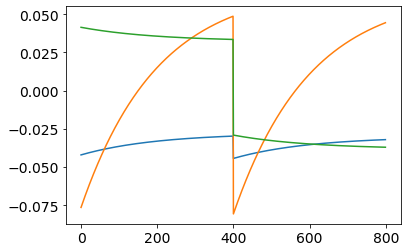

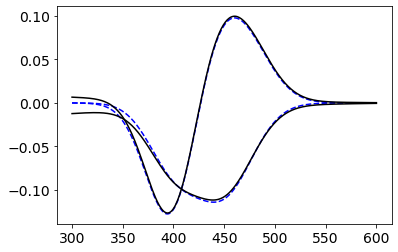

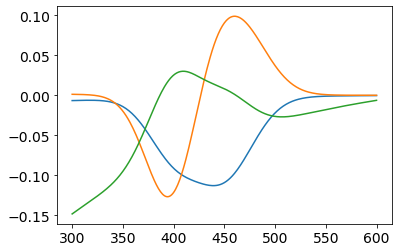

In [7]:
plt.plot(times, Ur, 'b', ls='--')
plt.plot(times, Urb, 'k')

plt.show()
plt.plot(t_mix, Urm)
plt.show()

plt.plot(wavelengths, VrT.T, 'b', ls='--')
plt.plot(wavelengths, VrTb.T, 'k')

plt.show()
plt.plot(wavelengths, VrTm.T)

plt.show()

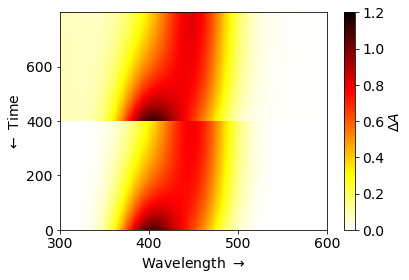

[190.62789984  35.17721405   7.94141803] 197.27889044875673
[190.62855347  35.1772195    7.46993196] 183.27562140098271
[190.629207    35.17722488   6.99834052] 170.1848853404434
[190.62986044  35.1772302    6.52665055] 158.00714204114882
[190.63051378  35.17723548   6.05486883] 146.7428189809027
[190.63116704  35.1772407    5.58300218] 136.39231138138092
[190.63182022  35.17724588   5.11105739] 126.95598224428161
[190.63247333  35.17725102   4.63904123] 118.43416238379874
[190.63312638  35.17725613   4.16696048] 110.82715045563772
[190.63377937  35.1772612    3.6948219 ] 104.13521298276218
[190.63443231  35.17726625   3.22263226] 98.35858437803384
[190.63508521  35.17727127   2.7503983 ] 93.49746696388407
[190.63573806  35.17727627   2.27812679] 89.55203098913479
[190.63639089  35.17728126   1.80582445] 86.52241464306526
[190.63704369  35.17728623   1.33349805] 84.40872406680558
[190.63769648  35.1772912    0.8611543 ] 83.21103336211942
[190.63834926  35.17729616   0.38879996] 82.9293

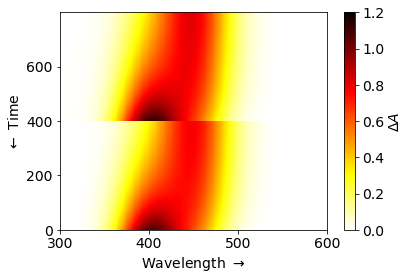

In [8]:
# D is correct, D_baseline is wrong, lets modify D_baseline to minimize the 3rd singular value and remove the baseline

def get_D_mix(D_subtr, D_baseline=D_baseline):
    D_baseline_modif = D_baseline - D_subtr
    return np.vstack((D,D_baseline_modif)), D_baseline_modif

_D_mix, D_baseline_modif = get_D_mix(0)
plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))

vectors = []
for i in range(18):
    Sr, Ur, VrT = get_svd_vectors(_D_mix)
#     print(Sr)
    V_subtr = np.outer(Ur[:, -1], VrT[-1])[times.shape[0]:].mean(axis=0)
    vectors.append(V_subtr)
#     plt.plot(wavelengths, V_subtr)
#     plt.show()
    _D_mix, D_baseline_modif = get_D_mix(V_subtr, D_baseline_modif)
    res = D - D_baseline_modif
    ssq = (res ** 2).sum()
    print(Sr, ssq)

plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))

vectors = np.asarray(vectors)


    
# plt.plot(wavelengths, VrT.T)
# plt.show()

# _D_mix = get_D_mix(-0.5*VrT[-1])
# plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))

# Sr, Ur, VrT = get_svd_vectors(_D_mix)
# plt.plot(wavelengths, VrT.T)
# plt.show()
# Sr

In [39]:
# plt.plot(wavelengths, vectors.T)
# plt.show()

_D_mix, _ = get_D_mix(0)
Sr, Ur, VrT = get_svd_vectors(_D_mix)
Sr
# plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))
coefs = VrT @ Baseline

bl_ = coefs @ VrT
coefs


array([-0.44081329, -0.14937524, -0.56022869])

In [204]:
from lmfit import Parameters, report_fit, Minimizer
from numpy.linalg import norm

params = Parameters()
params.add('t0', value=-1.44081329, min=-np.inf, max=np.inf, vary=True)
params.add('t1', value=-0.014937524, min=-np.inf, max=np.inf, vary=True)
params.add('t2', value=-5.56022869, min=-np.inf, max=np.inf, vary=True)

def residuals(params):
    pars = [par.value for key, par in params.items()]
    coefs = np.asarray(pars)
    
    bl_guess = coefs @ VrT
    
    _D_mix, _ = get_D_mix(bl_guess)
    _Sr, _Ur, _VrT = get_svd_vectors(_D_mix)
    _Sr[2:] = 0
    D_svd_filtered = _Ur @ np.diag(_Sr) @ _VrT
#     curv_baseline = 1e5*np.gradient(np.gradient(bl_guess))# / norm(bl_guess)

#     return _Sr.sum() + norm(curv_baseline)
#     return norm(curv_baseline)
    
#     print(norm(curv_baseline))
    
    return (D_svd_filtered - _D_mix) / norm(_D_mix)# + curv_baseline
    
#     return Sr.sum()
    
norm(residuals(params))

0.17213276359270574

In [205]:
minimizer = Minimizer(residuals, params, nan_policy='omit')

kwds = dict(jac='3-point', ftol=1e-10, xtol=1e-10, gtol= 1e-10, loss='linear', verbose=2)  
result = minimizer.minimize(method='least_squares', **kwds)  # minimize the residuals using TRF algorithm



   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4815e-02                                    1.56e-03    
       1              2         6.8614e-03      7.95e-03       5.74e+00       5.89e-04    
       2              3         2.3209e-03      4.54e-03       1.15e+01       1.25e-04    
       3              4         1.1255e-03      1.20e-03       1.15e+01       4.32e-05    
       4              5         4.3089e-04      6.95e-04       2.30e+01       1.03e-05    
       5              6         2.2464e-04      2.06e-04       2.30e+01       3.92e-06    
       6              7         9.2537e-05      1.32e-04       4.60e+01       1.04e-06    
       7              8         4.9913e-05      4.26e-05       4.60e+01       4.14e-07    
       8              9         2.1235e-05      2.87e-05       9.19e+01       1.16e-07    
       9             10         1.1576e-05      9.66e-06       9.19e+01       4.71e-08    

In [206]:
from IPython.display import display

display(result)

norm(residuals(result.params))



0.00039029164842021343

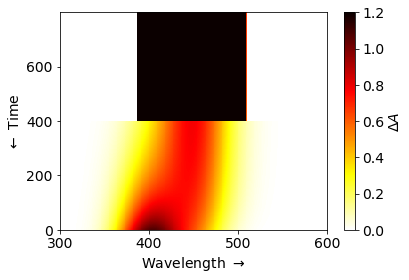

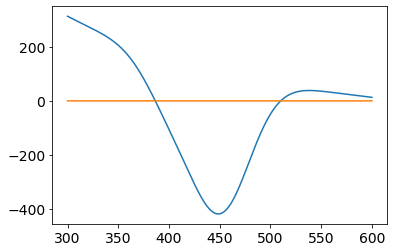

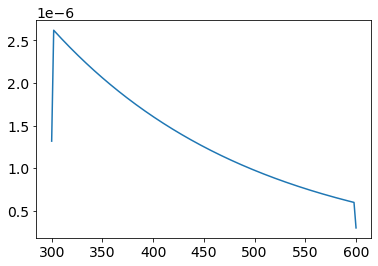

In [207]:
coefs = np.asarray([par.value for key, par in result.params.items()])
bl_guess = coefs @ VrT
_D_mix, _ = get_D_mix(bl_guess)
sigma, _, _ = get_svd_vectors(_D_mix)

plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))
plt.plot(wavelengths, bl_guess)
plt.plot(wavelengths, Baseline)

plt.show()
sigma

# plt.plot(wavelengths, np.gradient(np.gradient(bl_guess)))
plt.plot(wavelengths, np.gradient(np.gradient(Baseline)))

plt.show()

# plt.plot(wavelengths, Baseline)

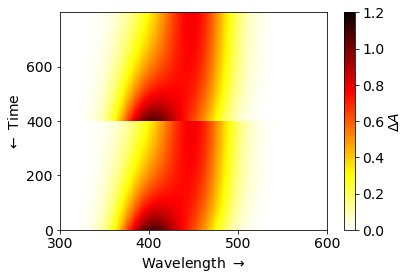

(301,)

In [31]:
_D_mix, _ = get_D_mix(1*Baseline)
plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))
Sr, _, _ = get_svd_vectors(_D_mix)

Sr.sum(), Sr


minimizer = Minimizer(residuals_direct_solve, params, nan_policy='omit', fcn_args=(D_noise,))

# pass additional arguments for TRF algorithm, for explanation, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
kwds = dict(jac='3-point', ftol=1e-8, xtol=1e-8, gtol= 1e-8, loss='linear', verbose=2)  
result = minimizer.minimize(method='least_squares', **kwds)  # minimize the residuals using TRF algorithm


# res = D - D_baseline_modif
# plot_matrix(times, wavelengths, res, cmap='seismic')
